In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/LUNA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,1.18,1.32,1.18,1.25,1.25,11700
1,1/3/2013,1.22,1.24,1.16,1.17,1.17,15800
2,1/4/2013,1.18,1.23,1.18,1.22,1.22,5600
3,1/7/2013,1.22,1.22,1.20,1.22,1.22,2500
4,1/8/2013,1.24,1.32,1.20,1.30,1.30,8500


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 174.760001.3, cost: -35665.839844, total money: 10119.220002
epoch: 20, total rewards: 177.200001.3, cost: -35697.242188, total money: 10062.100002
epoch: 30, total rewards: 189.300001.3, cost: -35722.531250, total money: 10086.530002
epoch: 40, total rewards: 139.860003.3, cost: -35770.925781, total money: 10043.830004
epoch: 50, total rewards: 119.920002.3, cost: -35782.152344, total money: 10035.710003
epoch: 60, total rewards: 156.389999.3, cost: -35777.234375, total money: 9989.410001
epoch: 70, total rewards: 151.580000.3, cost: -35781.804688, total money: 9986.740001
epoch: 80, total rewards: 123.819999.3, cost: -35822.546875, total money: 10000.050001
epoch: 90, total rewards: 108.349999.3, cost: -35814.636719, total money: 9960.950000
epoch: 100, total rewards: 135.639999.3, cost: -35818.222656, total money: 9980.300001
epoch: 110, total rewards: 143.249999.3, cost: -35829.972656, total money: 9994.730000
epoch: 120, total rewards: 150.479999.3, cost:

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 1.220000, total balance 9998.780000
day 3, sell 1 unit at price 1.220000, investment 0.000000 %, total balance 10000.000000,
day 5: buy 1 unit at price 1.350000, total balance 9998.650000
day 6: buy 1 unit at price 1.270000, total balance 9997.380000
day 7: buy 1 unit at price 1.330000, total balance 9996.050000
day 8, sell 1 unit at price 1.260000, investment -6.666669 %, total balance 9997.310000,
day 10: buy 1 unit at price 1.270000, total balance 9996.040000
day 11: buy 1 unit at price 1.260000, total balance 9994.780000
day 12: buy 1 unit at price 1.310000, total balance 9993.470000
day 13, sell 1 unit at price 1.330000, investment 4.724414 %, total balance 9994.800000,
day 14: buy 1 unit at price 1.280000, total balance 9993.520000
day 15, sell 1 unit at price 1.280000, investment -3.759404 %, total balance 9994.800000,
day 16: buy 1 unit at price 1.320000, total balance 9993.480000
day 18, sell 1 unit at price 1.320000, investment 3.937014 %, total bal

day 321: buy 1 unit at price 1.400000, total balance 9974.270001
day 322, sell 1 unit at price 1.360000, investment -12.258061 %, total balance 9975.630001,
day 325, sell 1 unit at price 1.520000, investment 0.662251 %, total balance 9977.150001,
day 326: buy 1 unit at price 1.540000, total balance 9975.610001
day 327: buy 1 unit at price 1.570000, total balance 9974.040001
day 328, sell 1 unit at price 1.570000, investment -5.421682 %, total balance 9975.610001,
day 329, sell 1 unit at price 1.560000, investment -2.500005 %, total balance 9977.170001,
day 333, sell 1 unit at price 1.440000, investment -7.096768 %, total balance 9978.610001,
day 334, sell 1 unit at price 1.440000, investment -10.559003 %, total balance 9980.050001,
day 337, sell 1 unit at price 1.410000, investment -12.962965 %, total balance 9981.460001,
day 338, sell 1 unit at price 1.410000, investment -15.060241 %, total balance 9982.870001,
day 339, sell 1 unit at price 1.440000, investment -13.772449 %, total bal

day 496: buy 1 unit at price 1.380000, total balance 9982.840001
day 497, sell 1 unit at price 1.440000, investment 1.408458 %, total balance 9984.280001,
day 501, sell 1 unit at price 1.430000, investment 0.000000 %, total balance 9985.710001,
day 503: buy 1 unit at price 1.420000, total balance 9984.290001
day 504: buy 1 unit at price 1.440000, total balance 9982.850001
day 505, sell 1 unit at price 1.430000, investment -2.721094 %, total balance 9984.280001,
day 509: buy 1 unit at price 1.620000, total balance 9982.660001
day 511: buy 1 unit at price 1.700000, total balance 9980.960001
day 516: buy 1 unit at price 1.610000, total balance 9979.350000
day 518: buy 1 unit at price 1.680000, total balance 9977.670001
day 520, sell 1 unit at price 1.610000, investment 11.034480 %, total balance 9979.280001,
day 522, sell 1 unit at price 1.640000, investment 13.888883 %, total balance 9980.920001,
day 523, sell 1 unit at price 1.680000, investment 14.285708 %, total balance 9982.600000,
d

day 822, sell 1 unit at price 1.110000, investment 26.136366 %, total balance 9974.820000,
day 823: buy 1 unit at price 1.090000, total balance 9973.730000
day 826: buy 1 unit at price 1.100000, total balance 9972.630000
day 827: buy 1 unit at price 1.060000, total balance 9971.570000
day 828: buy 1 unit at price 1.060000, total balance 9970.510000
day 829: buy 1 unit at price 1.060000, total balance 9969.450000
day 830, sell 1 unit at price 1.080000, investment 27.058825 %, total balance 9970.530000,
day 831: buy 1 unit at price 1.080000, total balance 9969.450000
day 832: buy 1 unit at price 1.070000, total balance 9968.380000
day 833: buy 1 unit at price 1.050000, total balance 9967.330000
day 834, sell 1 unit at price 1.070000, investment 27.380963 %, total balance 9968.400000,
day 835: buy 1 unit at price 1.030000, total balance 9967.370001
day 836, sell 1 unit at price 1.050000, investment 22.093016 %, total balance 9968.420000,
day 837, sell 1 unit at price 1.010000, investment 

day 979: buy 1 unit at price 1.520000, total balance 9956.570000
day 980, sell 1 unit at price 1.440000, investment 5.109493 %, total balance 9958.010000,
day 981: buy 1 unit at price 1.440000, total balance 9956.570000
day 983, sell 1 unit at price 1.490000, investment 9.558823 %, total balance 9958.060000,
day 984: buy 1 unit at price 1.440000, total balance 9956.620000
day 985, sell 1 unit at price 1.430000, investment 3.623185 %, total balance 9958.050000,
day 986, sell 1 unit at price 1.440000, investment 9.923673 %, total balance 9959.490000,
day 988: buy 1 unit at price 1.390000, total balance 9958.100000
day 990, sell 1 unit at price 1.350000, investment 0.000000 %, total balance 9959.450000,
day 991: buy 1 unit at price 1.310000, total balance 9958.140000
day 992: buy 1 unit at price 1.340000, total balance 9956.800000
day 993, sell 1 unit at price 1.400000, investment 4.477608 %, total balance 9958.200000,
day 994: buy 1 unit at price 1.370000, total balance 9956.830000
day 9

day 1156: buy 1 unit at price 1.160000, total balance 9938.950000
day 1157, sell 1 unit at price 1.190000, investment -38.659793 %, total balance 9940.140000,
day 1158: buy 1 unit at price 1.220000, total balance 9938.920000
day 1160, sell 1 unit at price 1.420000, investment -28.282831 %, total balance 9940.340000,
day 1163, sell 1 unit at price 1.520000, investment -22.051285 %, total balance 9941.860000,
day 1164, sell 1 unit at price 1.510000, investment -21.354165 %, total balance 9943.370000,
day 1165, sell 1 unit at price 1.460000, investment -20.218579 %, total balance 9944.830000,
day 1166, sell 1 unit at price 1.490000, investment -17.222219 %, total balance 9946.320000,
day 1169: buy 1 unit at price 1.380000, total balance 9944.940000
day 1170, sell 1 unit at price 1.430000, investment -22.702707 %, total balance 9946.370000,
day 1172, sell 1 unit at price 1.470000, investment -20.967741 %, total balance 9947.840000,
day 1176: buy 1 unit at price 1.590000, total balance 9946

day 1351: buy 1 unit at price 3.070000, total balance 9917.399999
day 1354, sell 1 unit at price 3.400000, investment 120.779232 %, total balance 9920.799999,
day 1355: buy 1 unit at price 3.240000, total balance 9917.559999
day 1356: buy 1 unit at price 3.260000, total balance 9914.299999
day 1357: buy 1 unit at price 3.260000, total balance 9911.039999
day 1358, sell 1 unit at price 3.360000, investment 116.774193 %, total balance 9914.399999,
day 1360: buy 1 unit at price 3.360000, total balance 9911.039999
day 1361, sell 1 unit at price 3.360000, investment 104.878044 %, total balance 9914.399999,
day 1362: buy 1 unit at price 3.350000, total balance 9911.049999
day 1364, sell 1 unit at price 3.310000, investment 99.397591 %, total balance 9914.359999,
day 1365: buy 1 unit at price 3.310000, total balance 9911.049999
day 1369, sell 1 unit at price 3.070000, investment 98.064518 %, total balance 9914.119999,
day 1370: buy 1 unit at price 3.070000, total balance 9911.049999
day 1371,

day 1535, sell 1 unit at price 3.170000, investment -2.760734 %, total balance 9871.290000,
day 1537: buy 1 unit at price 3.240000, total balance 9868.050000
day 1540: buy 1 unit at price 3.220000, total balance 9864.830000
day 1541: buy 1 unit at price 3.210000, total balance 9861.620000
day 1542: buy 1 unit at price 3.170000, total balance 9858.450000
day 1543: buy 1 unit at price 3.120000, total balance 9855.330000
day 1545, sell 1 unit at price 3.110000, investment -7.440476 %, total balance 9858.440000,
day 1546: buy 1 unit at price 3.210000, total balance 9855.230000
day 1548: buy 1 unit at price 3.300000, total balance 9851.930000
day 1549, sell 1 unit at price 3.210000, investment -4.179101 %, total balance 9855.140000,
day 1550: buy 1 unit at price 3.370000, total balance 9851.770000
day 1551, sell 1 unit at price 3.930000, investment 18.731122 %, total balance 9855.700000,
day 1553, sell 1 unit at price 3.830000, investment 24.755701 %, total balance 9859.530000,
day 1554, se

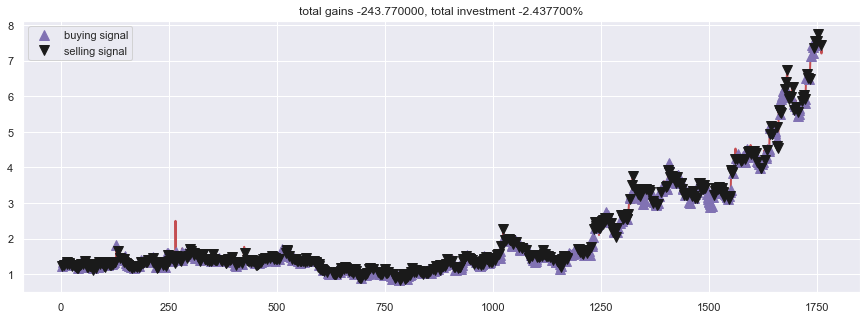

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()